In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from crossref.restful import Works
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from searchtweets import ResultStream, gen_rule_payload, load_credentials, \
    collect_results

## Helper Functions

In [108]:
def print_sentiment_scores(sentence, verbose=True, analyzer=SentimentIntensityAnalyzer()):
    """
        Returns sentiment scores of a given piece of text based on 
        user input of sentiment analysis algorithm.
        --------
    """
    snt = analyzer.polarity_scores(sentence)
    
    if(verbose):
        print("{:-<40} {}".format(sentence, str(snt)))
    return(sentence, snt)


def top_tokens(df, vectorizer, independent_var, number_of_tokens=10):
    """
        Returns a bar chart of the most common tokens given a particular
        vectorizer implementation
        --------
    """
    vectorizer_df = pd.DataFrame(vectorizer.fit_transform(df[independent_var]).toarray(),
                                 columns=vectorizer.get_feature_names())

    top_tokens = pd.DataFrame(vectorizer_df.sum(
        axis=0).sort_values(ascending=False).head(number_of_tokens))
    top_tokens.columns = ['Token_Count']
    
    plt.figure()
    ax = sns.barplot(x='Token_Count', y=top_tokens.index, data=top_tokens)
    
    return top_tokens


## API Call

In [111]:
call_limit = 10 # 10 is absolute minimum allowed (use for testing), 100 is max
start_date = "2018-09-01"
end_date = "2018-10-20"
kw_list = ["Self Driving Cars", "Artificial Intelligence", 
           "IOT", "Big Data"]

search_term = kw_list[0]
columns = ['text', 'created_at', 'retweet_count', 'quote_count', 
           'reply_count', 'favorite_count']

In [112]:
if __name__ == '__main__':
    try:
        print("ATTEMPTING TO RELOAD SAVED DATAFRAME...")
        df = pd.read_pickle("./Data/twitter_%s_analysis_%s.pkl" % (search_term, end_date))

    except FileNotFoundError:
        try:
            print("ATTEMPTING TO RELOAD RAW DATA...")
            raw_df = pd.read_pickle("./Data/twitter_raw_%s_%s.pkl" % (search_term, end_date))

        except FileNotFoundError:
            print("Querying Twitter API...")

            # Load Credentials
            premium_search_args = load_credentials(filename="./twitter_credentials.yaml",
                                                   yaml_key="search_tweets_premium_api",
                                                   env_overwrite=False)

            # Build payload
            rule = gen_rule_payload(search_term,
                                    from_date=start_date,
                                    to_date=end_date,
                                    results_per_call=call_limit)
            tweets = collect_results(rule,
                                     max_results=call_limit,
                                     result_stream_args=premium_search_args)

            raw_df = pd.DataFrame(tweets)  # Save raw scrape locally
            raw_df.to_pickle("./Data/twitter_raw_%s_%s.pkl" % (search_term, end_date))

        df = pd.DataFrame(raw_df[columns])
        df.to_pickle("./Data/twitter_%s_analysis_%s.pkl" % (search_term, end_date))  # Save final df locally

df.head()

/Users/andrewmartinez/anaconda3/lib/python3.7/site-packages/searchtweets/credentials.py:34: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  search_creds = yaml.load(f)[yaml_key]
Grabbing bearer token from OAUTH


ATTEMPTING TO RELOAD SAVED DATAFRAME...
ATTEMPTING TO RELOAD RAW DATA...
Querying Twitter API...


,text,created_at,retweet_count,quote_count,reply_count,favorite_count
0,This city is letting people try out self-drivi...,Fri Oct 19 23:59:32 +0000 2018,0,0,0,0
1,This city is letting people try out self-drivi...,Fri Oct 19 23:59:11 +0000 2018,0,0,0,0
2,This city is letting people try out self-drivi...,Fri Oct 19 23:58:43 +0000 2018,0,0,0,0
3,RT @mashable: Hit the road with a free self-dr...,Fri Oct 19 23:58:18 +0000 2018,0,0,0,0
4,RT @novapbs: An increase in autonomous vehicle...,Fri Oct 19 23:57:37 +0000 2018,0,0,0,0


## Top Tokens

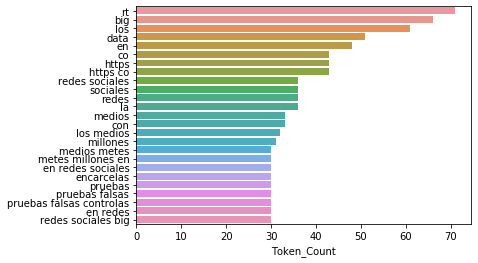

In [95]:
custom_stop_words = stopwords.words('english')
newStopWords = ['jats', 'lt', 'span', 'gt', 'de']
custom_stop_words.extend(newStopWords)

vectorizer = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1, 3))
title_tokens = top_tokens(df, vectorizer, 'text', number_of_tokens=25)

## Sentiment Analysis

In [96]:
sentiment_df = pd.DataFrame()

for x in df.loc[:,'text']:
    sentence, snt = print_sentiment_scores(x, verbose = False)
    temp = pd.DataFrame({'column1': [snt]})
    temp = pd.DataFrame(temp['column1'].values.tolist(), index=temp.index)
    temp['sentence'] = sentence
    sentiment_df = pd.concat([sentiment_df, temp], ignore_index=True)
    

In [97]:
sentiment_df = sentiment_df[['sentence', 'compound', 'neg', 'neu', 'pos']]
full_sentiment_df = df.join(sentiment_df)
full_sentiment_df = full_sentiment_df.drop(['sentence'], axis=1)

full_sentiment_df.head()

,text,created_at,retweet_count,quote_count,reply_count,favorite_count,compound,neg,neu,pos
0,RT @MonederoJC: Encarcelas a los lideres de la...,Mon Oct 29 23:59:56 +0000 2018,0,0,0,0,0.0000,0.000,1.000,0.000
1,RT @CIS_org: Recently released DHS data shows ...,Mon Oct 29 23:59:33 +0000 2018,0,0,0,0,0.5994,0.000,0.811,0.189
2,RT @MonederoJC: Encarcelas a los lideres de la...,Mon Oct 29 23:59:14 +0000 2018,0,0,0,0,0.0000,0.000,1.000,0.000
3,RT @GarbarzAriel: Atacar al enemigo en su nuev...,Mon Oct 29 23:59:06 +0000 2018,0,0,0,0,-0.5574,0.135,0.865,0.000
4,Proactive problem resolution! Advances in big ...,Mon Oct 29 23:59:02 +0000 2018,0,0,0,0,0.4926,0.120,0.620,0.261


## Create Count Dataframe

In [98]:
try:
    print('Fetching Final Twitter File...')
    full_df = pd.read_pickle("./Data/twitter_full_%s_%s.pkl" % (search_term, end_date))

except FileNotFoundError:
    print('File not found, recreating...')
    full_df = full_sentiment_df.copy()
    
    full_df['created_at'] = [date.strftime('%Y-%m-%d')
                             for date in pd.to_datetime(full_df['created_at'])]
    
    final_df = full_df.groupby('created_at').mean()
    final_df['count'] = full_df.groupby('created_at').agg('count')['text']
    final_df.to_pickle("./Data/twitter_full_%s_%s.pkl" % (search_term, end_date))

final_df

Fetching Final Twitter File...
File not found, recreating...


,retweet_count,quote_count,reply_count,favorite_count,compound,neg,neu,pos,count
created_at,,,,,,,,,
2018-10-29,0.16,0.01,0.01,0.32,0.109757,0.01653,0.92704,0.05646,100
